# 0. Import Required Packages

In [ ]:
# !pip install tscv

In [180]:
import math
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import decomposition, datasets
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
import lightgbm as lgb
import pickle
import joblib
# from tscv import GapWalkForward
import gc
from tqdm import tqdm


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
import warnings
warnings.filterwarnings("ignore")

In [181]:
# For CV score calculation
def corr_score(pred, valid):
    len_data = len(pred)
    mean_pred = np.sum(pred) / len_data
    mean_valid = np.sum(valid) / len_data
    var_pred = np.sum(np.square(pred - mean_pred)) / len_data
    var_valid = np.sum(np.square(valid - mean_valid)) / len_data

    cov = np.sum((pred * valid))/len_data - mean_pred*mean_valid
    corr = cov / np.sqrt(var_pred * var_valid)

    return corr

# 1. Data Wrangling
## 1.1 Predictors

In [183]:
data = pd.read_csv('./research_dataset_2022.csv', parse_dates=True, index_col=0)
spy = pd.read_csv('./SPY.csv', parse_dates=True, index_col=0)
data.dropna(subset=['trans_spy_open'], inplace=True)

data['DEF'] = data['BAA'] - data['AAA']
data['TERM'] = data['US10YR'] - data['US3M']
data['VRP'] = data['trans_VIX'] - data['garch']
#data['PCR'] = data['trans_spy_open'] / data['trans_SPGSCI']
data['PCR'] = np.log(spy['Open']) / data['trans_SPGSCI']
# the current price versus the past 10 month simple moving average.
#data['MA'] = data['trans_spy_open'] / data['trans_spy_open'].rolling(217).mean()
data['MA'] = np.log(spy['Open'] / spy['Open'].rolling(217).mean())

In [184]:
# CAY
X = data[['Consumption_new', 'Income_new']][1800:]; Y = data['Assets_new'][1800:]
LR = LinearRegression().fit(X, Y)
residual = -(Y - LR.predict(X))
data['CAY'] = [np.nan] * 1800 + residual.to_list()

In [185]:
# MOM
data['MOM'] = np.nan
for i in range(len(spy)):
    data['MOM'] = np.log(spy['Open'] / spy['Open'].shift(-12))

In [186]:
# OBV
spy['OBV'] = np.nan
spy['OBV'].iloc[0] = spy.iloc[0]['Volume']
for i in range(1,len(spy)):
    if spy.iloc[i]['Close'] > spy.iloc[i-1]['Close']:
        spy['OBV'].iloc[i] = spy.iloc[i-1]['OBV'] + spy.iloc[i]['Volume']
    elif spy.iloc[i]['Close'] < spy.iloc[i-1]['Close']:
        spy['OBV'].iloc[i] = spy.iloc[i-1]['OBV'] - spy.iloc[i]['Volume']
    else:
        spy['OBV'].iloc[i] = spy.iloc[i-1]['OBV']
data['OBV'] = np.log(spy['OBV'])

In [187]:
data = data.reset_index().rename(columns={'index':'Date'})

In [188]:
data.head()

,Date,US3M,US10YR,trans_TRAIL_12M_EPS_BEF_XO_ITEM,trans_PE_RATIO,trans_PX_OPEN,trans_PX_HIGH,trans_PX_LOW,trans_PX_LAST,trans_SPGSCI,trans_BDIY,trans_VIX,trans_PCUSEQTR,trans_MVOLE,trans_SPXDIV,trans_LAST_DPS_GROSS,trans_DXY,trans_BFCIUS,CPI,NOS,ASPY,advDecl,FedFunds,trans_NYSEADV,CBOE_leadIC,BAA,NOS_exDef_exAir,BER,vintageCPI,DividendToPriceRatio,PxToBook,AAA,SI,urflag,fdtrflag,ppiflag,TRAIL_12M_EPS_BEF_XO_ITEM.vintage,realVol,loan_corrected,VVIX,NAPMNEWO,NAPMPRIC,NAPMPMI,IRX,delinquency,bbyield,spxhigh,spxlow,htime,ltime,spxopen,spxclose,otime,ctime,Consumption_new,Assets_new,Income_new,trans_TYVIX,trans_IAP,trans_EPUCNUSD,del.corona,garch,hulbert.pred,rv_5on,sentiment1,etf.sentiment,sentiment2,sentiment3,median_earnings,diff_earnings_yield,US2Y,MICH,ICSA,TOM,SIM,FOMC,w5kftr,FOMC_2Day,PCT_MEMBERS_WITH_NEW_52W_HIGHS,PCT_MEMBERS_WITH_NEW_52_WK_LOWS,htaassi,TOM48,com_tom,CAPE,CATY,IC,sentiment4,sentiment5,sentiment6,sentiment7,princomp_SentDir,IND_PROD,SOTU,vs3,w5kgdp,wil5kGDPnow,fed_cor,term_ret,vix_cor,trans_spy_open,trans_IEF,trans_SKEW,trans_SPVXMP,trans_SPVXSP,trans_VXO,trans_VXD,trans_VXN,trans_RVX,trans_VIX3M,trans_VIX6M,trans_VIX9D,trans_VIX1Y,ETS,sentiment8,DEF,TERM,VRP,PCR,MA,CAY,MOM,OBV
0,1993-02-02,3.019,6.432,0.243737,0.731277,3.096296,2.984301,3.046897,3.078541,-0.615948,0.212436,-1.284332,NaN,NaN,-0.348974,1.225766,1.471461,0.780383,142.3,-0.020431,26.110614,0.971987,3.18,0.993804,28.6607,8.51,-0.002053,3.450327,142.2,0.027932,2.5677,7.80,4.15,0,1,0,17.37,3.949745,4.4,NaN,61.0,48.0,54.2,2.96,5.01,0.007806,442.87,440.76,53820.0,35040.0,442.52,442.72,30660.0,54000.0,10.037544,11.763424,9.86984,NaN,NaN,-1.568178,5.01,0.004367,0.000350,4.338725,53.448277,NaN,40.740829,NaN,4.988235,83.901688,4.258,89.3,341000.0,1,1,1,NaN,1.0,11.8,1.6,NaN,0,1,20.604814,28.144472,NaN,NaN,NaN,NaN,NaN,NaN,611.075005,0,0.000013,0.489696,NaN,0.00047,0.000552,0.000442,11.291943,NaN,0.928510,NaN,NaN,-1.751606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.002856,73.85,0.71,3.413,-1.288699,-6.151734,NaN,NaN,0.018545,13.432492
1,1993-02-03,2.977,6.410,0.241726,0.927155,3.079280,3.490660,3.233196,3.591356,-0.586115,0.191510,-1.343845,NaN,NaN,-0.327310,-0.443492,1.529786,0.448815,142.3,-0.020431,26.386655,1.069448,3.56,2.134437,28.8966,8.53,-0.002053,3.436435,142.2,0.027316,2.5944,7.80,4.15,0,0,0,17.37,6.831445,4.4,NaN,61.0,48.0,54.2,2.93,5.01,0.007806,447.35,442.57,53400.0,30660.0,442.57,447.15,30660.0,54000.0,10.037544,11.763424,9.86984,NaN,NaN,-0.882129,5.01,0.004591,0.000477,7.458867,53.448277,NaN,40.740829,NaN,4.971963,83.045982,4.234,89.3,341000.0,0,1,0,NaN,1.0,19.0,1.2,NaN,0,1,20.824030,28.439578,NaN,NaN,NaN,NaN,NaN,NaN,611.075005,0,-0.000188,0.489696,NaN,0.00047,0.000552,0.000442,9.836422,NaN,1.118645,NaN,NaN,-1.351545,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.005646,74.05,0.73,3.433,-1.348435,-6.472072,NaN,NaN,0.016318,14.007122
2,1993-02-04,2.977,6.374,0.239752,1.024803,3.595321,3.742118,3.733281,3.815224,-0.420579,0.190455,-1.252104,NaN,NaN,-0.042461,3.702126,1.579223,0.335535,142.3,-0.020431,26.497059,1.141443,3.08,2.217918,28.8545,8.50,-0.001007,3.486284,142.2,0.027548,2.6070,7.77,4.15,1,0,0,17.37,4.992247,4.4,NaN,61.0,48.0,54.2,2.90,5.01,0.007806,449.86,447.24,53520.0,30660.0,447.24,449.46,30660.0,54000.0,10.037544,11.763424,9.86984,NaN,NaN,-0.990649,5.01,0.004481,0.000465,6.130609,60.344826,NaN,40.740829,NaN,4.925926,82.479088,4.176,89.3,340000.0,0,1,0,NaN,0.0,26.8,0.4,NaN,0,0,20.937127,28.589415,NaN,NaN,NaN,NaN,NaN,NaN,611.075005,0,-0.000097,0.489696,NaN,0.00047,0.000552,0.000442,10.141009,NaN,1.024942,NaN,NaN,-1.105538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.005885,68.64,0.73,3.397,-1.256585,-9.049357,NaN,NaN,0.025336,14.370946
3,1993-02-05,2.966,6.306,0.237814,0.992944,3.807645,3.654553,3.651068,3.690097,-0.471812,0.308287,-0.937690,NaN,NaN,0.008543,-0.048274,1.529539,0.386605,142.3,-0.020431,26.478629,1.129946,2.87,0.007456,28.6849,8.48,-0.001007,3.500176,142.2,0.027509,2.6047,7.74,4.15,0,0,0,17.37,5.755161,4.4,NaN,61.0,48.0,54.2,2.90,5.01,0.007806,449.56,446.95,306

In [189]:
var = data[['DividendToPriceRatio', 'trans_PE_RATIO', 'PxToBook', 'CAPE',
            'bbyield', 'DEF', 'TERM', 'CAY', 'SIM', 'VRP', 'IC', 'trans_BDIY',
            'NOS', 'CPI', 'PCR', 'MA', 'OBV', 'MOM', 'SI', 'trans_MVOLE', 
            'BER', 'NAPMPRIC', 'CATY', 'IND_PROD']]
var.rename(columns = {'DividendToPriceRatio':'DP', 'trans_PE_RATIO':'PE',
                      'PxToBook':'BM', 'bbyield':'BY', 'trans_BDIY':'BDI',
                      'trans_MVOLE':'MVOLE', 'IND_PROD':'IP'}, inplace = True)
# Replace NaN Values with Zeros
var = var.fillna(0)

In [190]:
data.head()

,Date,US3M,US10YR,trans_TRAIL_12M_EPS_BEF_XO_ITEM,trans_PE_RATIO,trans_PX_OPEN,trans_PX_HIGH,trans_PX_LOW,trans_PX_LAST,trans_SPGSCI,trans_BDIY,trans_VIX,trans_PCUSEQTR,trans_MVOLE,trans_SPXDIV,trans_LAST_DPS_GROSS,trans_DXY,trans_BFCIUS,CPI,NOS,ASPY,advDecl,FedFunds,trans_NYSEADV,CBOE_leadIC,BAA,NOS_exDef_exAir,BER,vintageCPI,DividendToPriceRatio,PxToBook,AAA,SI,urflag,fdtrflag,ppiflag,TRAIL_12M_EPS_BEF_XO_ITEM.vintage,realVol,loan_corrected,VVIX,NAPMNEWO,NAPMPRIC,NAPMPMI,IRX,delinquency,bbyield,spxhigh,spxlow,htime,ltime,spxopen,spxclose,otime,ctime,Consumption_new,Assets_new,Income_new,trans_TYVIX,trans_IAP,trans_EPUCNUSD,del.corona,garch,hulbert.pred,rv_5on,sentiment1,etf.sentiment,sentiment2,sentiment3,median_earnings,diff_earnings_yield,US2Y,MICH,ICSA,TOM,SIM,FOMC,w5kftr,FOMC_2Day,PCT_MEMBERS_WITH_NEW_52W_HIGHS,PCT_MEMBERS_WITH_NEW_52_WK_LOWS,htaassi,TOM48,com_tom,CAPE,CATY,IC,sentiment4,sentiment5,sentiment6,sentiment7,princomp_SentDir,IND_PROD,SOTU,vs3,w5kgdp,wil5kGDPnow,fed_cor,term_ret,vix_cor,trans_spy_open,trans_IEF,trans_SKEW,trans_SPVXMP,trans_SPVXSP,trans_VXO,trans_VXD,trans_VXN,trans_RVX,trans_VIX3M,trans_VIX6M,trans_VIX9D,trans_VIX1Y,ETS,sentiment8,DEF,TERM,VRP,PCR,MA,CAY,MOM,OBV
0,1993-02-02,3.019,6.432,0.243737,0.731277,3.096296,2.984301,3.046897,3.078541,-0.615948,0.212436,-1.284332,NaN,NaN,-0.348974,1.225766,1.471461,0.780383,142.3,-0.020431,26.110614,0.971987,3.18,0.993804,28.6607,8.51,-0.002053,3.450327,142.2,0.027932,2.5677,7.80,4.15,0,1,0,17.37,3.949745,4.4,NaN,61.0,48.0,54.2,2.96,5.01,0.007806,442.87,440.76,53820.0,35040.0,442.52,442.72,30660.0,54000.0,10.037544,11.763424,9.86984,NaN,NaN,-1.568178,5.01,0.004367,0.000350,4.338725,53.448277,NaN,40.740829,NaN,4.988235,83.901688,4.258,89.3,341000.0,1,1,1,NaN,1.0,11.8,1.6,NaN,0,1,20.604814,28.144472,NaN,NaN,NaN,NaN,NaN,NaN,611.075005,0,0.000013,0.489696,NaN,0.00047,0.000552,0.000442,11.291943,NaN,0.928510,NaN,NaN,-1.751606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.002856,73.85,0.71,3.413,-1.288699,-6.151734,NaN,NaN,0.018545,13.432492
1,1993-02-03,2.977,6.410,0.241726,0.927155,3.079280,3.490660,3.233196,3.591356,-0.586115,0.191510,-1.343845,NaN,NaN,-0.327310,-0.443492,1.529786,0.448815,142.3,-0.020431,26.386655,1.069448,3.56,2.134437,28.8966,8.53,-0.002053,3.436435,142.2,0.027316,2.5944,7.80,4.15,0,0,0,17.37,6.831445,4.4,NaN,61.0,48.0,54.2,2.93,5.01,0.007806,447.35,442.57,53400.0,30660.0,442.57,447.15,30660.0,54000.0,10.037544,11.763424,9.86984,NaN,NaN,-0.882129,5.01,0.004591,0.000477,7.458867,53.448277,NaN,40.740829,NaN,4.971963,83.045982,4.234,89.3,341000.0,0,1,0,NaN,1.0,19.0,1.2,NaN,0,1,20.824030,28.439578,NaN,NaN,NaN,NaN,NaN,NaN,611.075005,0,-0.000188,0.489696,NaN,0.00047,0.000552,0.000442,9.836422,NaN,1.118645,NaN,NaN,-1.351545,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.005646,74.05,0.73,3.433,-1.348435,-6.472072,NaN,NaN,0.016318,14.007122
2,1993-02-04,2.977,6.374,0.239752,1.024803,3.595321,3.742118,3.733281,3.815224,-0.420579,0.190455,-1.252104,NaN,NaN,-0.042461,3.702126,1.579223,0.335535,142.3,-0.020431,26.497059,1.141443,3.08,2.217918,28.8545,8.50,-0.001007,3.486284,142.2,0.027548,2.6070,7.77,4.15,1,0,0,17.37,4.992247,4.4,NaN,61.0,48.0,54.2,2.90,5.01,0.007806,449.86,447.24,53520.0,30660.0,447.24,449.46,30660.0,54000.0,10.037544,11.763424,9.86984,NaN,NaN,-0.990649,5.01,0.004481,0.000465,6.130609,60.344826,NaN,40.740829,NaN,4.925926,82.479088,4.176,89.3,340000.0,0,1,0,NaN,0.0,26.8,0.4,NaN,0,0,20.937127,28.589415,NaN,NaN,NaN,NaN,NaN,NaN,611.075005,0,-0.000097,0.489696,NaN,0.00047,0.000552,0.000442,10.141009,NaN,1.024942,NaN,NaN,-1.105538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.005885,68.64,0.73,3.397,-1.256585,-9.049357,NaN,NaN,0.025336,14.370946
3,1993-02-05,2.966,6.306,0.237814,0.992944,3.807645,3.654553,3.651068,3.690097,-0.471812,0.308287,-0.937690,NaN,NaN,0.008543,-0.048274,1.529539,0.386605,142.3,-0.020431,26.478629,1.129946,2.87,0.007456,28.6849,8.48,-0.001007,3.500176,142.2,0.027509,2.6047,7.74,4.15,0,0,0,17.37,5.755161,4.4,NaN,61.0,48.0,54.2,2.90,5.01,0.007806,449.56,446.95,306

## 1.2 Principle Component

In [191]:
std_slc = StandardScaler()
pca = decomposition.PCA(n_components=1)

# PCA_Price
X_price = var.loc[:, ['DP','PE','BM','CAPE']]
X_price_std = std_slc.fit_transform(X_price)
PCA_price = pca.fit_transform(X_price_std)
var.insert(loc=4, column='PCA_Price', value=PCA_price)

# PCA Tech
X_tech = var.loc[:, ['MA','OBV','MOM']]
X_tech_std = std_slc.fit_transform(X_tech)
PCA_tech = pca.fit_transform(X_tech_std)
var.insert(loc=19, column='PCA_Tech', value=PCA_tech)

var = var.drop(['DP','PE','BM','CAPE', 'MA','OBV','MOM'], axis=1)

## 1.3 Correlation between Predictors

<AxesSubplot:>

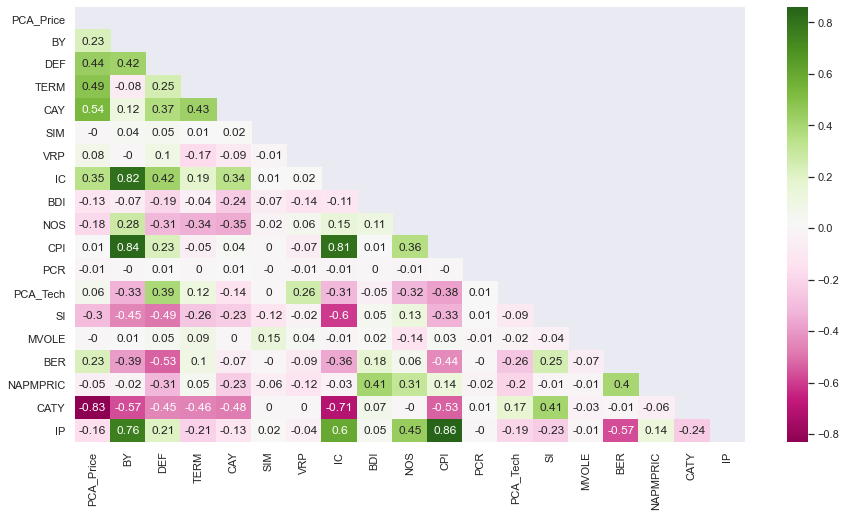

In [192]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(np.round(var.corr(), 2), mask=np.triu(np.ones_like(var.corr(), dtype=np.bool)), 
           cmap="PiYG", annot=True)

## 1.4 PCA to Aviod Multicollinearity

In [193]:
# PCA_Econ
X_econ = var.loc[:, ['BY','IC','CPI','IP']]
X_econ_std = std_slc.fit_transform(X_econ)
PCA_econ = pca.fit_transform(X_econ_std)
var.insert(loc=19, column='PCA_Econ', value=PCA_econ)

# new PCA_Price
var['DP'] = data['DividendToPriceRatio']; var['PE'] = data['trans_PE_RATIO']
var['BM'] = data['PxToBook']; var['CAPE'] = data['CAPE']
X_price_new = var.loc[:, ['DP','PE','BM','CAPE', 'CATY']]
X_price_new_std = std_slc.fit_transform(X_price_new)
PCA_price_new = pca.fit_transform(X_price_new_std)
var.insert(loc=1, column='PCA_Price_New', value=PCA_price_new)

var = var.drop(['BY','IC','CPI','IP', 'DP','PE','BM','CAPE', 'CATY', 'PCA_Price'], axis=1)

<AxesSubplot:>

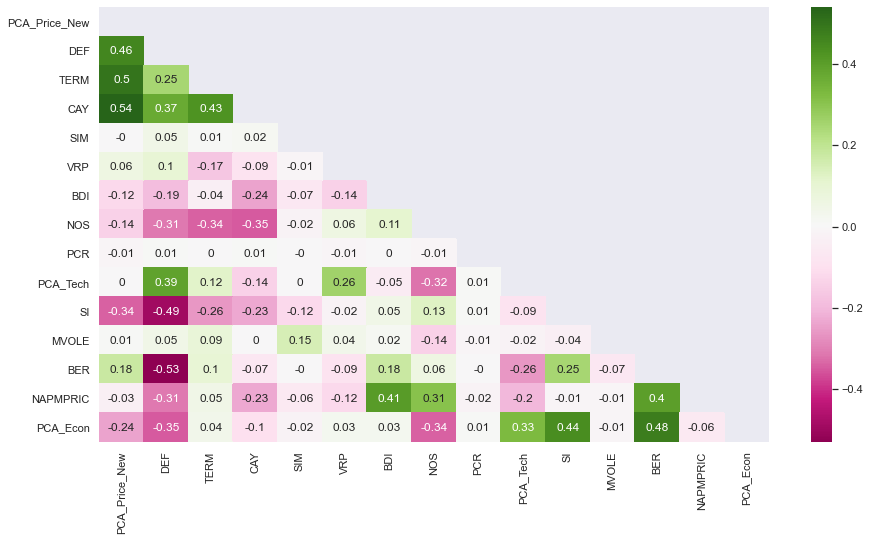

In [194]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(np.round(var.corr(), 2), mask=np.triu(np.ones_like(var.corr(), dtype=np.bool)), 
           cmap="PiYG", annot=True)

In [200]:
data_ori = pd.concat([data['Date'], var], axis=1)

## 1.5 Future Returns

### Log returns
In order to analyze price changes for an asset we can deal with the price difference. However, different assets exhibit different price scales, so that the their returns are not readily comparable. We can solve this problem by computing the percentage change in price instead, also known as the return. This return coincides with the percentage change in our invested capital.

Returns are widely used in finance, however log returns are preferred for mathematical modelling of time series, as they are additive across time. Also, while regular returns cannot go below -100%, log returns are not bounded.

To compute the log return, we can simply take the logarithm of the ratio between two consecutive prices. The first row will have an empty return as the previous value is unknown, therefore the empty return data point will be dropped.

In [344]:
# -*- coding: utf-8 -*-
# Create new features
import pandas as pd
import numpy as np
import time

class FeatureWorkerClass(object):
    def __init__(self, target_code):
        self.target_col = target_code
        
    # define function to compute log returns
#     @staticmethod
#     def create_log_return(df, target_col, periods=1):
#         return_df = df.copy()
# #         return_df['log_return'] = np.log(return_df[target_col]).diff(periods=periods).shift(-1)
#         return_df['log_return'] = return_df[target_col].diff(periods=periods).shift(-1)
# #         return_df['log_return'] = return_df[target_col].diff(periods=periods)
#         return return_df
#     @staticmethod
#     def create_log_return(df, target_col, days=7, periods=1):
#         return_df = df.copy()
# #         return_df['log_return'] = np.log(return_df[target_col]).diff(periods=periods).shift(-1)
#         return_df['log_return'] = np.log(return_df[target_col] / return_df[target_col].shift(-days))
# #         return_df['log_return'] = return_df[target_col].diff(periods=periods)
#         return return_df
    @staticmethod
    def create_log_return(df, target_col, days=22, periods=1):
        return_df = df.copy()
#         return_df['log_return'] = np.log(return_df[target_col]).diff(periods=periods).shift(-1)
        return_df[f'{days}_return'] = (return_df[target_col].shift(-days) - return_df[target_col]) / return_df[target_col]
#         return_df['log_return'] = return_df[target_col].diff(periods=periods)
        return return_df
    
    # create log_close/mean features
    @staticmethod
    def create_log_close_mean_features(df, target_col, lags=[2, 3, 5, 10, 20, 30]):
        lcm_df = df.copy()
        for lag in lags:
            lcm_df[f'log_close/mean_{lag}'] = np.log( np.array(lcm_df[target_col]) \
                                                     / np.roll(np.append(np.convolve( np.array(lcm_df[target_col]), \
                                                                                     np.ones(lag)/lag, mode="valid"), np.ones(lag-1)), lag-1))
            
            lcm_df[f'log_return_{lag}'] = np.log(np.array(lcm_df[target_col]) \
                                                    /  np.roll(np.array(lcm_df[target_col]), lag))
        return lcm_df

    # create lag features
    @staticmethod
    def create_lag_features(df, target_col, lags):
        lag_df = df.copy()
        for i in lags:
            lag_df[f'{target_col}_lag_{i}'] = lag_df[target_col].shift(i).values
        return lag_df

    # create rolling features: mean, max, min, median, std
    @staticmethod
    def create_rolling_features(df, target_col, windows, min_periods=1, shift=1):
        rolling_shift_df = df.copy()
        for w in windows:
            shift_df = rolling_shift_df[target_col].shift(shift).rolling(
                window=w, 
                min_periods=min_periods
                ).agg([ 'max', 'mean', 'min', 'median', np.nanstd], axis=1
                ).rename(columns={
                        'max': "_rmax_{}".format(w),
                        'mean': "_rmean_{}".format(w),
                        'min': "_rmin_{}".format(w),
                        'median': "_rmedian_{}".format(w),
                        'nanstd': "_rstd_{}".format(w),
                        }).reset_index()
            shift_df.columns = [''.join(col) for col in shift_df.columns]
            del shift_df['index']
            rolling_shift_df[list(shift_df.columns)] = shift_df
            
        return rolling_shift_df

    # create rolling skew features
    @staticmethod
    def create_rskew_features(df, target_col, windows, min_periods=2, shift=1):
        rolling_rskew_df = df.copy()
        for w in windows:
            rolling_rskew_df[f'{target_col}_rskew_{w}'] = \
                rolling_rskew_df[target_col].shift(shift).rolling(
                    window=w,
                    min_periods=min_periods
                ).skew().fillna(0).values
        return rolling_rskew_df

    # create diff features
    @staticmethod
    def create_diff_features(df, target_col, periods=[1], shift=1):
        diff_df = df.copy()
        for p in periods:
            diff_df[f'{target_col}_diff_{p}'] = \
                diff_df[target_col].shift(shift).diff(periods=p).abs().values
        return diff_df

    # create percentage change features
    @staticmethod
    def create_pct_change_features(df, target_col, periods=[1], shift=1):
        pct_change_df = df.copy()
        for p in periods:
            pct_change_df[f'{target_col}_pct_change_{p}'] = \
                pct_change_df[target_col].shift(shift).pct_change(periods=p).replace(np.inf,0).fillna(0).abs().values
        return pct_change_df

    # Creating exponentially weighted mean features
    @staticmethod
    def create_ewm_features(df, target_col, alpha=[0.9], shift=[1]):
        ewm_df = df.copy()
        for a in alpha:
            for s in shift:
                ewm_df[f'{target_col}_ewm_{a}_{s}'] = \
                    ewm_df[target_col].shift(s).ewm(alpha=a).mean().values
        return ewm_df
    
    @staticmethod
    def create_kdj_features(df, target_col, min_periods=2, windows=[10], com=[2], shift=1):
        kdj_df = df.copy()
        for c in com:
            for w in windows:
                lowest = kdj_df[target_col].shift(shift).rolling(window=w, min_periods=min_periods).min()
                highest = kdj_df[target_col].shift(shift).rolling(window=w, min_periods=min_periods).max()
                rsv = (kdj_df[target_col].shift(shift) - lowest) / (highest - lowest) * 100
                rsv.fillna(value = 100.0, inplace=True)

                k = rsv.ewm(com=c, adjust=False).mean()
                kdj_df[f'{target_col}_kdj_{c}_{w}'] = 3 * k - 2 * k.ewm(com=c, adjust=False).mean()
        return kdj_df
    
    @staticmethod
    def create_normal_features(df):
        n_df = df.copy()
        n_df['Upper_Shadow'] = n_df['High'] - np.maximum(n_df['Close'], n_df['Open'])
        n_df['Lower_Shadow'] = np.minimum(n_df['Close'], n_df['Open']) - n_df['Low']
        # n_df['hlco_ratio'] = (n_df['High'] - n_df['Low'])/(n_df['Close'] - n_df['Open']+1)
        return n_df
        
    def create_origin_features(self, df):
        matrix_df = df.copy()
        
        matrix = self.create_lag_features(df=matrix_df,
                                                    target_col=self.target_col,
                                                    lags=[1])
        print("lag feature over.......................") 
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())))
        
        
    def create_return_features(self, df):
        matrix_df = df.copy()
        
        matrix_df = self.create_log_return(df=matrix_df,
                                            target_col=self.target_col
                                                       )
        print("log_return feature over.......................")
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())))
        
        
        return matrix_df
        
        
    
    def create_lag_return_features(self, df):
        matrix_df = df.copy()
        
        
        matrix_df = self.create_lag_features(df=matrix_df,
                                             target_col=self.target_col,
                                             lags=[1,2,3,4,5,6,7])
        print("lag feature over.......................") 
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())))

 
        matrix_df = self.create_rolling_features(df=matrix_df,
                                                    target_col=self.target_col,
                                                    shift=0,
                                                    windows=[2, 3, 4, 8, 12, 16, 30])
        print("rolling feature over.......................")
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())))
        
        matrix_df = self.create_log_close_mean_features(df=matrix_df,
                                                    target_col=self.target_col,
                                                    lags=[2, 3, 5, 10, 20, 30]
                                                       )
        print("log_close_mean feature over.......................")
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())))

        matrix_df = self.create_pct_change_features(df=matrix_df,
                                                    target_col=self.target_col,
                                                    shift=0,
                                                    periods=[1, 2, 3, 4, 8, 12, 16, 30])
        print("pct change feature over.......................")
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())))


        matrix_df = self.create_ewm_features(df=matrix_df,
                                             target_col=self.target_col,
                                             alpha=[0.8, 0.5],
                                             shift=[3, 4, 8, 12, 16, 30])
        print("ewm feature over.......................")
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())))
        
        matrix_df = self.create_rskew_features(df=matrix_df,
                                             target_col=self.target_col,
                                             windows=[4, 8, 12, 16, 48], 
                                             min_periods=2, 
                                             shift=0)
        print("rskew feature over.......................")
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())))
        
        matrix_df = self.create_kdj_features(df=matrix_df,
                                             target_col=self.target_col,
                                             min_periods=2, 
                                             windows=[7, 10, 20, 30], 
                                             com=[1, 2],
                                             shift=0)
        print("kdj feature over.......................")
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())))
        
        return matrix_df
    
    
    def create_test_features(self, df, shift=0):
        matrix_df = df.copy()
        
        
#         matrix_df = self.create_lag_features(df=matrix_df,
#                                              target_col=self.target_col,
#                                              lags=[1,2])
#         print("lag feature over.......................") 
#         print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())))

 
#         matrix_df = self.create_rolling_features(df=matrix_df,
#                                                     target_col=self.target_col,
#                                                     shift=1,
#                                                     windows=[2, 3, 4, 8, 12, 16, 48])
#         print("rolling feature over.......................")
#         print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())))
#         matrix_df = self.create_log_close_mean_features(df=matrix_df,
#                                                     target_col=self.target_col,
#                                                     lags=[2, 3, 5, 10, 20, 30],
#                                                         shift=0
#                                                        )
#         print("log_close_mean feature over.......................")
#         print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())))

        matrix_df = self.create_pct_change_features(df=matrix_df,
                                                    target_col=self.target_col,
                                                    shift=0,
                                                    periods=[1, 2, 3, 4, 8, 12, 16, 30])
        print("pct change feature over.......................")
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())))


        matrix_df = self.create_ewm_features(df=matrix_df,
                                             target_col=self.target_col,
                                             alpha=[0.95, 0.5],
                                             shift=[1, 2, 3, 4, 8, 12, 16, 30])
        print("ewm feature over.......................")
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())))
        
#         matrix_df = self.create_rskew_features(df=matrix_df,
#                                              target_col=self.target_col,
#                                              windows=[2, 3, 4, 8, 12, 16, 48], 
#                                              min_periods=2, 
#                                              shift=1)
#         print("rskew feature over.......................")
#         print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())))
        
        matrix_df = self.create_kdj_features(df=matrix_df,
                                             target_col=self.target_col,
                                             min_periods=2, 
                                             windows=[7, 10, 20, 30], 
                                             com=[1, 2])
        print("kdj feature over.......................")
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())))
        
        return matrix_df


In [345]:
spy = pd.read_csv('./SPY.csv', parse_dates=True, index_col=0)
spy = spy.reset_index()

In [346]:
spy.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1993-02-01,43.96875,44.25000,43.96875,44.25000,25.619022,480500
1,1993-02-02,44.21875,44.37500,44.12500,44.34375,25.673304,201300
2,1993-02-03,44.40625,44.84375,44.37500,44.81250,25.944695,529400
3,1993-02-04,44.96875,45.09375,44.46875,45.00000,26.053236,531500
4,1993-02-05,44.96875,45.06250,44.71875,44.96875,26.035154,492100


In [347]:
# FeatureWorkerClass('Close').create_rolling_features(spy, 'Close', windows=[3])

In [348]:
# FeatureWorkerClass('Close').create_log_return(spy, 'Close', 2)

In [349]:
# spy_log

In [350]:
spy_log = FeatureWorkerClass('Close').create_return_features(spy.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)).drop(['Close'], axis=1)
spy_log['year'] = spy_log['Date'].apply(lambda x: int(str(x)[0:4]))
spy_log['month'] = spy_log['Date'].apply(lambda x: int(str(x)[5:7]))
spy_log['day'] = spy_log['Date'].apply(lambda x: int(str(x)[8:10]))

log_return feature over.......................
2022-07-24 02:38:08


In [351]:
spy_log = spy_log.iloc[:-22, :]

In [352]:
# sns.distplot(np.log(spy['Close']))

In [353]:
spy_log.tail()

,Date,22_return,year,month,day
7282,2021-12-30,-0.048744,2021,12,30
7283,2021-12-31,-0.037077,2021,12,31
7284,2022-01-03,-0.065123,2022,1,3
7285,2022-01-04,-0.060412,2022,1,4
7286,2022-01-05,-0.045092,2022,1,5


In [354]:
# spy['Close'] = np.log(spy['Close'])

In [355]:
# FeatureWorkerClass('Close').create_normal_features(spy).drop([])

In [356]:
matrix_df = FeatureWorkerClass('Close').create_normal_features(spy)

In [357]:
matrix_df = FeatureWorkerClass('Close').create_lag_return_features(matrix_df).drop(['Open', 'High', 'Low', 'Close'], axis=1)

lag feature over.......................
2022-07-24 02:38:19
rolling feature over.......................
2022-07-24 02:38:19
log_close_mean feature over.......................
2022-07-24 02:38:19
pct change feature over.......................
2022-07-24 02:38:19
ewm feature over.......................
2022-07-24 02:38:19
rskew feature over.......................
2022-07-24 02:38:19
kdj feature over.......................
2022-07-24 02:38:20


In [358]:
matrix_df.head()

,Date,Adj Close,Volume,Upper_Shadow,Lower_Shadow,Close_lag_1,Close_lag_2,Close_lag_3,Close_lag_4,Close_lag_5,Close_lag_6,Close_lag_7,_rmax_2,_rmean_2,_rmin_2,_rmedian_2,_rstd_2,_rmax_3,_rmean_3,_rmin_3,_rmedian_3,_rstd_3,_rmax_4,_rmean_4,_rmin_4,_rmedian_4,_rstd_4,_rmax_8,_rmean_8,_rmin_8,_rmedian_8,_rstd_8,_rmax_12,_rmean_12,_rmin_12,_rmedian_12,_rstd_12,_rmax_16,_rmean_16,_rmin_16,_rmedian_16,_rstd_16,_rmax_30,_rmean_30,_rmin_30,_rmedian_30,_rstd_30,log_close/mean_2,log_return_2,log_close/mean_3,log_return_3,log_close/mean_5,log_return_5,log_close/mean_10,log_return_10,log_close/mean_20,log_return_20,log_close/mean_30,log_return_30,Close_pct_change_1,Close_pct_change_2,Close_pct_change_3,Close_pct_change_4,Close_pct_change_8,Close_pct_change_12,Close_pct_change_16,Close_pct_change_30,Close_ewm_0.8_3,Close_ewm_0.8_4,Close_ewm_0.8_8,Close_ewm_0.8_12,Close_ewm_0.8_16,Close_ewm_0.8_30,Close_ewm_0.5_3,Close_ewm_0.5_4,Close_ewm_0.5_8,Close_ewm_0.5_12,Close_ewm_0.5_16,Close_ewm_0.5_30,Close_rskew_4,Close_rskew_8,Close_rskew_12,Close_rskew_16,Close_rskew_48,Close_kdj_1_7,Close_kdj_1_10,Close_kdj_1_20,Close_kdj_1_30,Close_kdj_2_7,Close_kdj_2_10,Close_kdj_2_20,Close_kdj_2_30
0,1993-02-01,25.619022,480500,0.00000,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.25000,44.250000,44.25000,44.250000,NaN,44.25000,44.250000,44.25000,44.250000,NaN,44.25000,44.250000,44.25000,44.250000,NaN,44.25000,44.250000,44.25,44.250000,NaN,44.25000,44.250000,44.25,44.250000,NaN,44.25000,44.250000,44.25,44.250000,NaN,44.25000,44.250000,44.25,44.250000,NaN,3.789855,-2.316499,3.789855,-2.311808,3.789855,-2.325926,3.789855,-2.284272,3.789855,-2.353278,3.789855,-2.378206,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,1993-02-02,25.673304,201300,0.03125,0.09375,44.25000,NaN,NaN,NaN,NaN,NaN,NaN,44.34375,44.296875,44.25000,44.296875,0.066291,44.34375,44.296875,44.25000,44.296875,0.066291,44.34375,44.296875,44.25000,44.296875,0.066291,44.34375,44.296875,44.25,44.296875,0.066291,44.34375,44.296875,44.25,44.296875,0.066291,44.34375,44.296875,44.25,44.296875,0.066291,44.34375,44.296875,44.25,44.296875,0.066291,0.001058,-2.311168,3.791972,-2.314383,3.791972,-2.333477,3.791972,-2.279643,3.791972,-2.360229,3.791972,-2.375272,0.002119,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2,1993-02-03,25.944695,529400,0.03125,0.03125,44.34375,44.25000,NaN,NaN,NaN,NaN,NaN,44.81250,44.578125,44.34375,44.578125,0.331456,44.81250,44.468750,44.25000,44.343750,0.301364,44.81250,44.468750,44.25000,44.343750,0.301364,44.81250,44.468750,44.25,44.343750,0.301364,44.81250,44.468750,44.25,44.343750,0.301364,44.81250,44.468750,44.25,44.343750,0.301364,44.81250,44.468750,44.25,44.343750,0.301364,0.005244,0.012632,0.007700,-2.300653,3.802487,-2.299176,3.802487,-2.264178,3.802487,-2.352413,3.802487,-2.366035,0.010571,0.012712,0.000000,0.000000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.545393,1.545393,1.545393,1.545393,1.545393,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
3,1993-02-04,26.053236,531500,0.09375,0.50000,44.81250,44.34375,44.25000,NaN,NaN,NaN,NaN,45.00000,44.906250,44.81250,44.906250,0.132583,45.00000,44.718750,44.34375,44.812500,0.338020,45.00000,44.601562,44.25000,44.578125,0.362082,45.00000,44.601562,44.25,44.578125,0.362082,45.00000,44.601562,44.25,44.578125,0.362082,45.00000,44.601562,44.25,44.578125,0.362082,45.00000,44.601562,44.25,44.578125,0.362082,0.002086,0.014691,0.006270,0.016807,3.806662,-2.299692,3.806662,-2.284534,3.806662,-2.334364,3.806662,-2.359091,0.004184,0.014799,0.016949,0.000000,0.0,0.0,0.0,0.0,44.250000,NaN,NaN,NaN,NaN,NaN,44.2500,NaN,NaN,NaN,N

In [359]:
# np.log(spy['Close']).diff(2)

In [360]:
spy_log.head()

,Date,22_return,year,month,day
0,1993-02-01,0.014124,1993,2,1
1,1993-02-02,0.009161,1993,2,2
2,1993-02-03,0.020921,1993,2,3
3,1993-02-04,0.013194,1993,2,4
4,1993-02-05,0.015983,1993,2,5


In [361]:
data_ori.tail()

,Date,PCA_Price_New,DEF,TERM,CAY,SIM,VRP,BDI,NOS,PCR,PCA_Tech,SI,MVOLE,BER,NAPMPRIC,PCA_Econ
7304,2022-02-02,-2.527231,0.68,1.5900,-0.1248,1,0.260503,-1.247980,0.04485,2.162632,-0.504007,3.543710,-1.014133,2.4272,76.1,-2.196593
7305,2022-02-03,-2.258122,0.57,1.6404,-0.1248,1,0.683729,-1.225233,0.04485,2.096109,-0.415408,3.553919,-0.792912,2.4083,76.1,-2.196593
7306,2022-02-04,-2.275808,0.52,1.6853,-0.1248,1,0.465799,-1.210591,0.04485,1.969693,-0.327882,3.492266,-0.788274,2.4119,76.1,-2.196593
7307,2022-02-07,-2.240460,0.65,1.7054,-0.1248,1,0.395275,-1.195652,0.04485,2.047572,-0.380284,3.456699,-0.908974,2.4102,76.1,-2.196593
7308,2022-02-08,-2.322516,0.65,1.6983,-0.1248,1,0.151261,-1.107975,0.04485,0.000000,1.905152,3.412222,-0.946572,2.4288,76.1,-2.195656


In [362]:
data_ori.isna().sum()

Date             0
PCA_Price_New    0
DEF              0
TERM             0
CAY              0
SIM              0
VRP              0
BDI              0
NOS              0
PCR              0
PCA_Tech         0
SI               0
MVOLE            0
BER              0
NAPMPRIC         0
PCA_Econ         0
dtype: int64

In [363]:
# sorted(na.items(), key=lambda x: x[1], reverse=True)

In [364]:
# drop_col = \
# ['wil5kGDPnow'
#  ,'w5kftr'
#  ,'trans_VIX9D'
#  ,'htaassi'
#  ,'trans_VIX6M'
#  ,'trans_VIX1Y'
#  ,'VVIX'
#  ,'IC'
#  ,'etf.sentiment'
#  ,'trans_SPVXMP'
#  ,'trans_SPVXSP'
#  ,'trans_IAP'
#  ,'trans_MVOLE'
#  ,'trans_RVX'
#  ,'trans_TYVIX'
#  ,'trans_IEF'
#  ,'trans_VIX3M'
#  ,'trans_VXN'
#  ,'CAY'
#  ,'princomp_SentDir'
#  ,'sentiment4'
#  ,'sentiment5'
#  ,'sentiment6'
#  ,'sentiment7'
#  ,'trans_VXD'
#  ,'OBV'
#  ,'trans_PCUSEQTR'
#  ,'sentiment3']

# data_drop = data.drop(drop_col, axis=1).fillna(0)

In [365]:
# spy_log  = spy[['Date', 'Close']]

In [366]:
mg = pd.merge(data_ori, spy_log, on=['Date'])
mg = pd.merge(mg, matrix_df, on=['Date'])
# mg = pd.merge(matrix_df, spy_log, on=['Date'])

In [367]:
sorted(mg.corr()['22_return'].items(), key=lambda x: abs(x[1]), reverse=True)

[('22_return', 1.0),
 ('_rstd_30', 0.11518585548466682),
 ('Close_pct_change_30', 0.10950489886608254),
 ('NAPMPRIC', -0.09283114458437874),
 ('_rstd_16', 0.08400749174364208),
 ('VRP', 0.08360117771884093),
 ('BDI', 0.08354161726325243),
 ('Close_pct_change_16', 0.08128945732703659),
 ('Close_pct_change_4', 0.07900936166911657),
 ('CAY', 0.07880715202010848),
 ('_rstd_12', 0.0765711690597904),
 ('Close_pct_change_8', 0.07437961210692044),
 ('_rstd_8', 0.07397826661276283),
 ('Close_pct_change_12', 0.07345350980933689),
 ('PCA_Price_New', 0.07169235940954398),
 ('SIM', 0.07103886587526055),
 ('Upper_Shadow', 0.06703082903462673),
 ('Close_pct_change_3', 0.06503394330264003),
 ('Close_kdj_1_30', -0.06434102252268334),
 ('PCA_Tech', -0.06422497168554012),
 ('_rstd_4', 0.06314599070323361),
 ('Close_kdj_2_30', -0.060541567606447605),
 ('MVOLE', 0.05707218769786133),
 ('_rstd_3', 0.05701002642704842),
 ('NOS', -0.05566348242299542),
 ('TERM', -0.05387504972564244),
 ('Close_kdj_1_20', -0.0

In [368]:
mg.tail()

,Date,PCA_Price_New,DEF,TERM,CAY,SIM,VRP,BDI,NOS,PCR,PCA_Tech,SI,MVOLE,BER,NAPMPRIC,PCA_Econ,22_return,year,month,day,Adj Close,Volume,Upper_Shadow,Lower_Shadow,Close_lag_1,Close_lag_2,Close_lag_3,Close_lag_4,Close_lag_5,Close_lag_6,Close_lag_7,_rmax_2,_rmean_2,_rmin_2,_rmedian_2,_rstd_2,_rmax_3,_rmean_3,_rmin_3,_rmedian_3,_rstd_3,_rmax_4,_rmean_4,_rmin_4,_rmedian_4,_rstd_4,_rmax_8,_rmean_8,_rmin_8,_rmedian_8,_rstd_8,_rmax_12,_rmean_12,_rmin_12,_rmedian_12,_rstd_12,_rmax_16,_rmean_16,_rmin_16,_rmedian_16,_rstd_16,_rmax_30,_rmean_30,_rmin_30,_rmedian_30,_rstd_30,log_close/mean_2,log_return_2,log_close/mean_3,log_return_3,log_close/mean_5,log_return_5,log_close/mean_10,log_return_10,log_close/mean_20,log_return_20,log_close/mean_30,log_return_30,Close_pct_change_1,Close_pct_change_2,Close_pct_change_3,Close_pct_change_4,Close_pct_change_8,Close_pct_change_12,Close_pct_change_16,Close_pct_change_30,Close_ewm_0.8_3,Close_ewm_0.8_4,Close_ewm_0.8_8,Close_ewm_0.8_12,Close_ewm_0.8_16,Close_ewm_0.8_30,Close_ewm_0.5_3,Close_ewm_0.5_4,Close_ewm_0.5_8,Close_ewm_0.5_12,Close_ewm_0.5_16,Close_ewm_0.5_30,Close_rskew_4,Close_rskew_8,Close_rskew_12,Close_rskew_16,Close_rskew_48,Close_kdj_1_7,Close_kdj_1_10,Close_kdj_1_20,Close_kdj_1_30,Close_kdj_2_7,Close_kdj_2_10,Close_kdj_2_20,Close_kdj_2_30
7281,2021-12-30,-3.057335,0.69,1.4779,-0.133651,1,-0.581745,-0.818924,0.04485,4.318257,-0.963599,3.596155,0.075087,2.6129,82.4,-2.19388,-0.048744,2021,12,30,472.643646,55329000,1.070007,0.489991,477.480011,476.869995,477.260010,470.600006,467.690002,463.059998,454.980011,477.480011,476.820007,476.160004,476.820008,0.933386,477.480011,476.836670,476.160004,476.869995,0.660634,477.480011,476.942505,476.160004,477.065002,0.579450,477.480011,470.512505,454.980011,473.380005,8.204174,477.480011,468.698336,454.980011,469.145004,7.462621,477.480011,468.597502,454.980011,468.604995,6.466957,477.480011,465.901337,450.5,467.630004,7.121957,-0.001385,-0.001490,-0.001420,-0.002307,0.001021,0.017948,0.015062,0.011745,0.019912,0.055396,0.021780,0.014554,0.002765,0.001489,0.002305,0.011815,0.035423,0.020554,0.016828,0.014661,475.763664,469.778278,461.300300,467.248436,466.190153,468.876649,472.386644,467.513279,463.552394,467.518291,462.552642,467.991905,-1.001286,-1.069713,-0.350125,-0.326106,-0.177477,96.936314,99.930820,98.867982,99.461509,108.510759,109.217020,106.273423,106.677115
7282,2021-12-31,-3.030254,0.66,1.4797,-0.133651,1,-0.600855,-0.807832,0.04485,4.942270,-0.918229,3.632607,-0.427043,2.5947,82.4,-2.19388,-0.037077,2021,12,31,471.452484,65237400,1.219970,0.289978,476.160004,477.480011,476.869995,477.260010,470.600006,467.690002,463.059998,476.160004,475.559997,474.959991,475.559998,0.848537,477.480011,476.200002,474.959991,476.160004,1.260486,477.480011,476.367500,474.959991,476.515000,1.082331,477.480011,473.010002,463.059998,475.559998,5.342299,477.480011,469.665003,454.980011,470.600006,7.459557,477.480011,468.937502,454.980011,469.145004,6.658848,477.480011,466.128669,450.5,467.630004,7.302439,-0.001262,-0.005292,-0.002607,-0.004013,-0.003334,0.009222,0.010726,0.018080,0.015509,0.037672,0.018769,0.014463,0.002520,0.005278,0.004005,0.004819,0.043914,0.025035,0.011586,0.014568,476.648729,475.763664,456.244069,464.137675,468.854022,468.287342,474.628320,472.386644,459.266202,465.439138,466.036315,468.065960,-0.680141,-1.108575,-0.715415,-0.407681,-0.197442,75.790748,90.999511,90.920838,92.202728,89.961286,101.072816,98.949631,100.010387
7283,2022-01-03,-3.093392,0.58,1.5748,-0.133651,1,-0.721532,-0.797158,0.04485,4.644243,-0.900781,3.644463,-0.468240,2.6468,82.4,-2.19388,-0.065123,2022,1,3,474.182190,72668200,0.140015,2.449982,474.959991,476.160004,477.480011,476.869995,477.260010,470.600006,467.690002,477.709991,476.334991,474.959991,476.334991,1.944544,477.709991,476.276662,474.959991,476.160004,1.378707,477.709991,476.577499,474.959991,476.820008,1.276414,477.709991,474.841251,467.690002,476.515000,3.704064,477.709991,470.257502,454.980011,472.779998

In [369]:
X = mg.copy()
# X = pd.concat([X[['Date', 'Close']], X.drop(['Date', 'Close'], axis=1).shift(1)], axis=1).dropna()
# X = pd.concat([X[['Date', 'log_return']], X.drop(['Date', 'log_return'], axis=1).shift(1)], axis=1).dropna()

X_train = X.iloc[30:-30, :].drop(['22_return'], axis=1)
X_test = X.iloc[-30:, :].drop(['22_return'], axis=1).reset_index()
y_train = X.iloc[30:-30, :][['22_return']]
y_test = X.iloc[-30:, :][['22_return']].reset_index()

In [370]:
# X_test_1D = pd.merge(X.iloc[-30:, :], matrix_df.iloc[-30:, :], on='Date').drop(['log_return'], axis=1)

In [371]:
# y = X[['Close']]
# X = X.drop(['Close'], axis=1)

## Training

In [372]:
# define features for LGBM
not_use_features_train = ['Date']

features = X_train.columns 
features = features.drop(not_use_features_train)
features = list(features)
# display(features)  
len(features)

109

In [242]:
# from: https://blog.amedama.jp/entry/lightgbm-cv-feature-importance
# (used in nyanp's Optiver solution)
def plot_importance(importances, features_names = features, PLOT_TOP_N = 20, figsize=(10, 10)):
    importance_df = pd.DataFrame(data=importances, columns=features)
    sorted_indices = importance_df.median(axis=0).sort_values(ascending=False).index
    sorted_importance_df = importance_df.loc[:, sorted_indices]
    plot_cols = sorted_importance_df.columns[:PLOT_TOP_N]
    _, ax = plt.subplots(figsize=figsize)
    ax.grid()
    ax.set_xscale('log')
    ax.set_ylabel('Feature')
    ax.set_xlabel('Importance')
    sns.boxplot(data=sorted_importance_df[plot_cols],
                orient='h',
                ax=ax)
    plt.show()

In [243]:
# del data
# del mg
# gc.collect()

In [244]:
# X_train, X_test = X.iloc[:-30, :], X.iloc[-30:, :]
# y_train, y_test = y.iloc[:-30, :], y.iloc[-30:, :]

In [373]:
df = mg.copy()
# X = pd.concat([X[['Date', 'Close']], X.drop(['Date', 'Close'], axis=1).shift(1)], axis=1).dropna()
# X = pd.concat([X[['Date', 'log_return']], X.drop(['Date', 'log_return'], axis=1).shift(1)], axis=1).dropna()

X = df.iloc[30:].drop(['22_return'], axis=1)
y = df.iloc[30:][['22_return']]

In [246]:
def kf_lgbm(F, X_train, y_train):
    seed0 = 0
    params = {
        'early_stopping_rounds': 50,
        'objective': 'regression',
        'metric': 'rmse',
    #     'metric': 'None',
        'boosting_type': 'gbdt',
        'max_depth': 5,
        'verbose': -1,
        'max_bin':600,
        'min_data_in_leaf':50,
        'learning_rate': 0.03,
        'subsample': 0.8,
        'subsample_freq': 1,
        'feature_fraction': 1,
        'lambda_l1': 0.5,
        'lambda_l2': 1,
        'seed':seed0,
        'feature_fraction_seed': seed0,
        'bagging_fraction_seed': seed0,
        'drop_seed': seed0,
        'data_random_seed': seed0,
        'extra_trees': True,
        'extra_seed': seed0,
        'zero_as_missing': True,
        "first_metric_only": True,
#         "device": "gpu",
#         "gpu_platform_id": 0,
#         "gpu_device_id": 0,
             }
    fold = F
    # cv = GapWalkForward(n_splits=fold, gap_size=100, test_size=22)
    cv = KFold(n_splits = fold, random_state = 2021, shuffle = True)
    importances = []
    oof_pred = []
    oof_valid = []
    for split, train_test_split in enumerate(cv.split(X_train)):
        gc.collect()
        train_index, val_index = train_test_split
    #     train_X, train_Y = X_train.iloc[train_index, :].copy(), y_train.iloc[train_index, :].copy()
    #     val_X, val_Y = X_train.iloc[val_index, :].copy(), y_train.iloc[val_index, :].copy()
    #     print(train_X.tail())
        train_dataset = lgb.Dataset(X_train.iloc[train_index, 1:],
                                        y_train.iloc[train_index, :].values, 
                                        feature_name = features, 
                                       )
        val_dataset = lgb.Dataset(X_train.iloc[val_index, 1:], 
                                      y_train.iloc[val_index, :].values, 
                                      feature_name = features, 
                                     )
        print(f"number of train data: {len(X_train.iloc[train_index])}")
        print(f"number of val data:   {len(X_train.iloc[val_index])}")
        model = lgb.train(params = params,
                              train_set = train_dataset, 
                              valid_sets=[train_dataset, val_dataset],
                              valid_names=['tr', 'vl'],
                              num_boost_round = 10000,
                              verbose_eval = 2000,     
    #                           feval = rmse,
                             )
        importances.append(model.feature_importance(importance_type='gain'))
        file = f'trained_model_fold{split}.pkl'
        pickle.dump(model, open(file, 'wb'))
        print(f"Trained model was saved to 'trained_model_fold{split}.pkl'")
        print("")

#         oof_pred += list(model.predict(X_train.iloc[val_index, 1:]))
#         oof_valid += list(y_train.iloc[val_index, :].values)


#     plot_importance(np.array(importances),features, PLOT_TOP_N = 20, figsize=(10, 5))
    return model



In [255]:
def rolling_predict(X, y, tr_num, test_num):
    all_pred = list()
    all_y = list()
    for i in tqdm(range(int(len(X.iloc[tr_num:])/test_num))):
        print('Train data num: {}'.format(tr_num))
        print('Test data num: {}'.format(test_num))
        num = i * test_num
        train_X = X.iloc[num:tr_num+num]
        train_y = y.iloc[num:tr_num+num]
        test_X = X.iloc[tr_num+num:tr_num+num+test_num]
        test_y = y.iloc[tr_num+num:tr_num+num+test_num]
#         print(test_X.head())
        if num % 22 == 0:
            fold = 5
            kf_lgbm(fold, train_X, train_y)
        pred = []
        for i in range(fold):
            model = joblib.load(f"./trained_model_fold{i}.pkl")
            pred.append(model.predict(test_X.iloc[:, 1:]))
        y_pred = np.mean(pred, axis=0)
        
        all_pred += list(y_pred)
        all_y += list(test_y.values)
    return all_pred, all_y
        
    
    

In [ ]:
all_pred, all_y = rolling_predict(X, y, 6000, 1)

0.002481229857426371


<AxesSubplot:xlabel='Date', ylabel='value'>

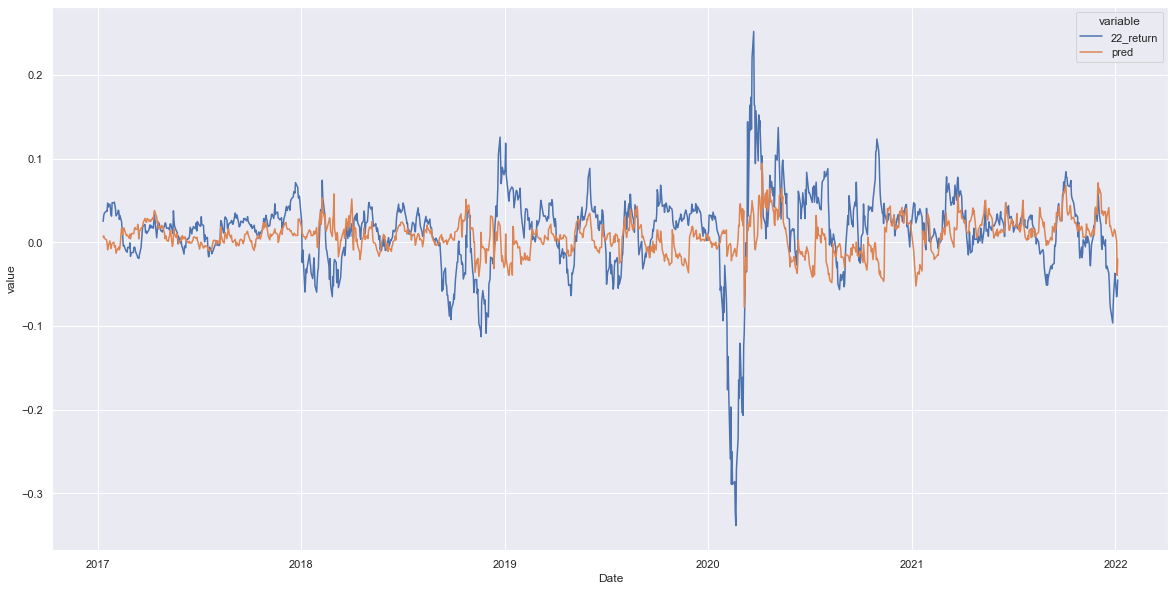

In [374]:
tmp = y.iloc[6000:7256].copy()
# tmp.rename()
# tmp = pd.DataFrame()
# tmp['22_return'] = list(y.iloc[6000:7254].values)
tmp['pred'] = all_pred
tmp['Date'] = X.iloc[6000:]['Date']
lgbm_rmse = mse(all_pred, all_y)
print(lgbm_rmse)
ml = pd.melt(tmp, id_vars=['Date'])
plt.figure(figsize=(20, 10))
sns.lineplot(data=ml, x='Date', y='value', hue='variable')

In [293]:
def predict_y(model, X, y, tr_num, test_num):
    all_pred = list()
    all_y = list()
    for i in tqdm(range(int(len(X.iloc[tr_num:])/test_num))):
        print('Train data num: {}'.format(tr_num))
        print('Test data num: {}'.format(test_num))
        num = i * test_num
        train_X = X.iloc[num:tr_num+num, 1:].values
        train_y = y.iloc[num:tr_num+num].values
        test_X = X.iloc[tr_num+num:tr_num+num+test_num, 1:].values
        test_y = y.iloc[tr_num+num:tr_num+num+test_num].values
        if num % 22 == 0:
             model.fit(train_X, train_y)
        y_pred = model.predict(test_X)
        # print(y_pred)
        try:
            all_pred.extend(list(y_pred[0]))
        except:
            all_pred.append(y_pred[0])
        all_y.extend(test_y)
    return all_pred, all_y

## 2.1 Kitchen Sinking Regression

In [378]:
lr = LinearRegression()
lr_pred, _ = predict_y(lr, X, y, 6000, 1)

  0%|          | 1/1256 [00:00<03:02,  6.88it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

  1%|▏         | 16/1256 [00:00<01:38, 12.60it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


  3%|▎         | 34/1256 [00:00<00:59, 20.67it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000


  3%|▎         | 43/1256 [00:00<00:45, 26.64it/s]

Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


  5%|▍         | 58/1256 [00:01<00:34, 34.88it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

  5%|▌         | 67/1256 [00:01<00:31, 38.15it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

  7%|▋         | 88/1256 [00:01<00:21, 54.18it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


  8%|▊         | 96/1256 [00:01<00:23, 48.84it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


  9%|▉         | 117/1256 [00:02<00:21, 52.01it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 10%|█         | 126/1256 [00:02<00:19, 58.28it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 11%|█         | 134/1256 [00:02<00:21, 52.31it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 12%|█▏        | 152/1256 [00:02<00:16, 65.34it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 13%|█▎        | 169/1256 [00:02<00:17, 61.14it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 14%|█▍        | 177/1256 [00:03<00:20, 52.36it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 15%|█▍        | 187/1256 [00:03<00:17, 60.69it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 16%|█▌        | 203/1256 [00:03<00:18, 58.39it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 17%|█▋        | 215/1256 [00:03<00:15, 66.70it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 19%|█▊        | 233/1256 [00:03<00:14, 68.27it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 19%|█▉        | 241/1256 [00:03<00:14, 69.62it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 20%|██        | 257/1256 [00:04<00:15, 63.38it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 21%|██        | 265/1256 [00:04<00:17, 55.16it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 23%|██▎       | 283/1256 [00:04<00:15, 64.16it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 23%|██▎       | 291/1256 [00:04<00:17, 55.70it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 24%|██▍       | 302/1256 [00:04<00:14, 64.81it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 26%|██▌       | 321/1256 [00:05<00:13, 68.97it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 26%|██▋       | 331/1256 [00:05<00:13, 66.15it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 28%|██▊       | 353/1256 [00:05<00:12, 75.04it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 29%|██▉       | 365/1256 [00:05<00:10, 84.45it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 31%|███       | 384/1256 [00:06<00:12, 70.44it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 31%|███▏      | 394/1256 [00:06<00:11, 76.06it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 33%|███▎      | 412/1256 [00:06<00:12, 70.13it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 33%|███▎      | 420/1256 [00:06<00:13, 61.77it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 35%|███▌      | 440/1256 [00:06<00:11, 71.27it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 36%|███▌      | 448/1256 [00:07<00:14, 55.11it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 37%|███▋      | 463/1256 [00:07<00:16, 47.02it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 38%|███▊      | 472/1256 [00:07<00:14, 54.58it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 38%|███▊      | 480/1256 [00:07<00:13, 57.97it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 40%|███▉      | 497/1256 [00:07<00:12, 60.48it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 40%|████      | 507/1256 [00:08<00:12, 59.02it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000


 42%|████▏     | 528/1256 [00:08<00:10, 72.69it/s]

Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 43%|████▎     | 537/1256 [00:08<00:10, 65.73it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 45%|████▍     | 559/1256 [00:08<00:10, 65.49it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 45%|████▌     | 569/1256 [00:08<00:09, 71.03it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 47%|████▋     | 586/1256 [00:09<00:09, 67.31it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 47%|████▋     | 595/1256 [00:09<00:10, 62.05it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 48%|████▊     | 605/1256 [00:09<00:09, 69.00it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 50%|████▉     | 627/1256 [00:09<00:08, 75.10it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 51%|█████     | 639/1256 [00:09<00:08, 72.36it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 52%|█████▏    | 653/1256 [00:09<00:07, 84.16it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 54%|█████▎    | 675/1256 [00:10<00:07, 81.67it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 55%|█████▌    | 696/1256 [00:10<00:07, 71.95it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 56%|█████▌    | 705/1256 [00:10<00:08, 61.72it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 57%|█████▋    | 716/1256 [00:10<00:07, 68.04it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 59%|█████▉    | 738/1256 [00:11<00:07, 73.48it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 60%|█████▉    | 749/1256 [00:11<00:07, 65.20it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1

 61%|██████    | 769/1256 [00:11<00:06, 72.06it/s]


Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 62%|██████▏   | 777/1256 [00:11<00:07, 62.45it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1

 63%|██████▎   | 786/1256 [00:11<00:06, 68.59it/s]


Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 64%|██████▍   | 806/1256 [00:12<00:06, 70.43it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 65%|██████▍   | 815/1256 [00:12<00:06, 63.95it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 67%|██████▋   | 836/1256 [00:12<00:05, 77.73it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 68%|██████▊   | 857/1256 [00:12<00:05, 78.70it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 69%|██████▉   | 866/1256 [00:13<00:05, 66.54it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 70%|██████▉   | 877/1256 [00:13<00:05, 75.49it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 71%|███████▏  | 895/1256 [00:13<00:05, 68.20it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 72%|███████▏  | 903/1256 [00:13<00:06, 55.87it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 73%|███████▎  | 911/1256 [00:13<00:06, 57.33it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 74%|███████▎  | 926/1256 [00:14<00:06, 52.59it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 75%|███████▍  | 936/1256 [00:14<00:05, 61.19it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 75%|███████▌  | 944/1256 [00:14<00:04, 64.57it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 77%|███████▋  | 962/1256 [00:14<00:04, 63.21it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 78%|███████▊  | 979/1256 [00:14<00:04, 62.41it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 79%|███████▉  | 991/1256 [00:15<00:04, 61.10it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 80%|███████▉  | 1003/1256 [00:15<00:03, 70.64it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 82%|████████▏ | 1026/1256 [00:15<00:03, 74.18it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 83%|████████▎ | 1046/1256 [00:15<00:02, 73.94it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 85%|████████▍ | 1064/1256 [00:16<00:02, 67.77it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 86%|████████▌ | 1074/1256 [00:16<00:02, 72.42it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 87%|████████▋ | 1094/1256 [00:16<00:02, 72.59it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 88%|████████▊ | 1103/1256 [00:16<00:02, 65.46it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 89%|████████▉ | 1123/1256 [00:16<00:01, 68.79it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 90%|█████████ | 1133/1256 [00:16<00:01, 75.55it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 91%|█████████ | 1144/1256 [00:17<00:01, 82.64it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 92%|█████████▏| 1161/1256 [00:17<00:01, 70.52it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 94%|█████████▍| 1178/1256 [00:17<00:01, 62.25it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 95%|█████████▍| 1189/1256 [00:17<00:01, 61.49it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 96%|█████████▌| 1208/1256 [00:18<00:00, 74.47it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 98%|█████████▊| 1228/1256 [00:18<00:00, 72.00it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 98%|█████████▊| 1237/1256 [00:18<00:00, 62.54it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 99%|█████████▉| 1249/1256 [00:18<00:00, 71.59it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


100%|██████████| 1256/1256 [00:18<00:00, 66.84it/s]

Train data num: 6000
Test data num: 1


In [379]:
# tmp = y.iloc[2600:7256].copy()
# # tmp.rename()
# # tmp = pd.DataFrame()
# # tmp['22_return'] = list(y.iloc[6000:7254].values)
# tmp['pred'] = lr_pred
# tmp['Date'] = X.iloc[2600:]['Date']
# ml = pd.melt(tmp, id_vars=['Date'])
# plt.figure(figsize=(20, 10))
# sns.lineplot(data=ml, x='Date', y='value', hue='variable')

In [380]:
# count = tmp.copy()
# count = count.drop(['Date'], axis=1).cumsum()
# count['Date'] = tmp['Date']
# ml_count = pd.melt(count, id_vars=['Date'])
# plt.figure(figsize=(20, 10))
# sns.lineplot(data=ml_count, x='Date', y='value', hue='variable')

0.0024061999513012885


<AxesSubplot:xlabel='Date', ylabel='value'>

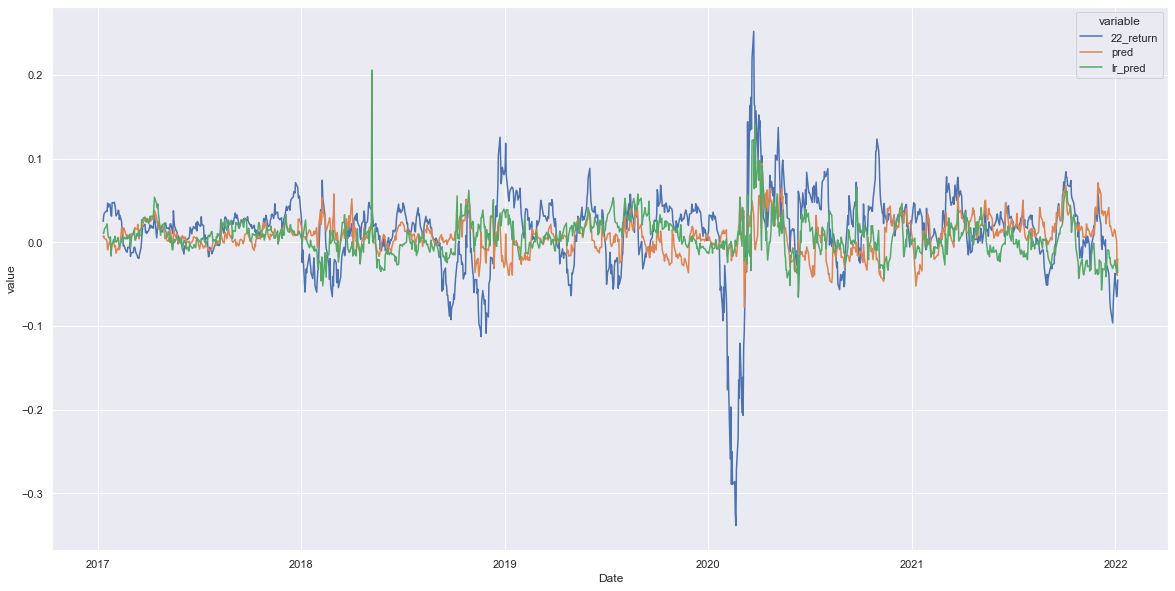

In [382]:
# tmp = y.iloc[6000:7256].copy()
# tmp = pd.DataFrame()
# tmp['22_return'] = list(y.iloc[6000:7254].values)
tmp['lr_pred'] = lr_pred
# tmp['Date'] = X.iloc[6000:]['Date']
lr_rmse = mse(lr_pred, all_y)
print(lr_rmse)
ml = pd.melt(tmp, id_vars=['Date'])
plt.figure(figsize=(20, 10))
sns.lineplot(data=ml, x='Date', y='value', hue='variable')

## 2.2 Correlation Screening

In [313]:
corr = sorted(abs(round(pd.concat([X, y], axis=1).corr()['log_return'], 3)).items(), key=lambda x: x[1], reverse=True)

In [318]:
X_cs = X[[c[0] for c in corr[1:20]]]
cs = LinearRegression()
cs_pred, _ = predict_y(cs, X_cs, y, 6000, 1)

 11%|█         | 133/1256 [00:00<00:00, 1316.85it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data n

 31%|███       | 384/1256 [00:00<00:00, 1228.20it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data n

 54%|█████▍    | 683/1256 [00:00<00:00, 1349.49it/s]

Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data nu

 78%|███████▊  | 978/1256 [00:00<00:00, 1394.53it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data n

100%|██████████| 1256/1256 [00:00<00:00, 1392.38it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data n

0.0028311113882005428


<AxesSubplot:xlabel='Date', ylabel='value'>

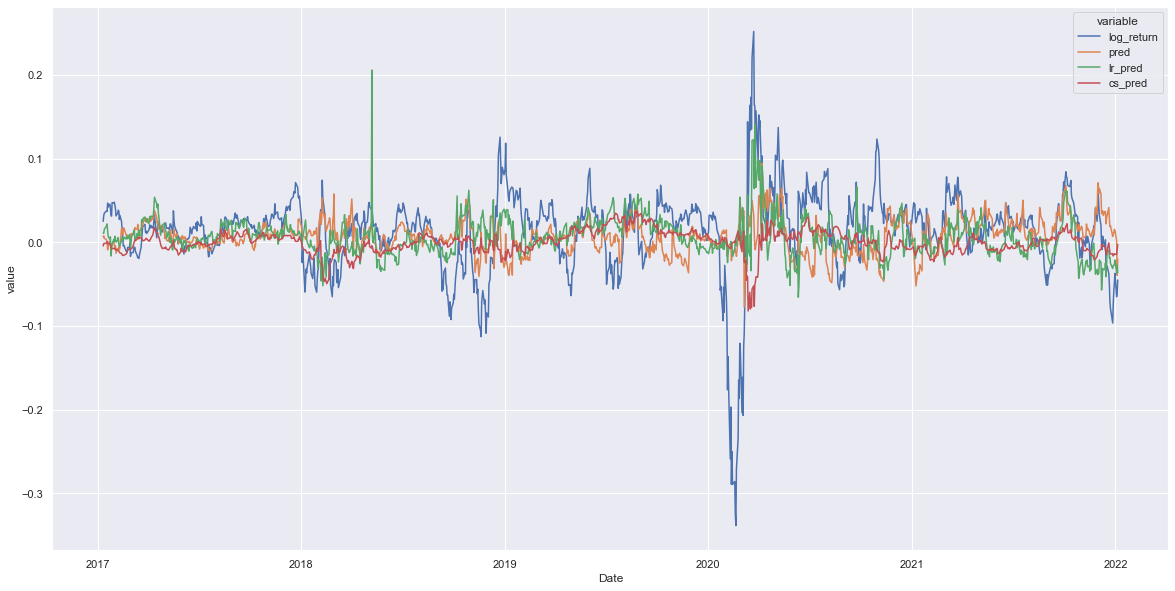

In [332]:
tmp['cs_pred'] = cs_pred
cs_rmse = mse(cs_pred, all_y)
print(cs_rmse)
ml = pd.melt(tmp, id_vars=['Date'])
plt.figure(figsize=(20, 10))
sns.lineplot(data=ml, x='Date', y='value', hue='variable')

## 2.3 LASSO Regression

In [397]:
# X_col = var.columns.drop(['1MReturn', '3MReturn', '6MReturn', '1YReturn'])
X_scaled = std_slc.fit_transform(X.iloc[:, 1:])
X_scaled = pd.DataFrame(data = X_scaled, columns = X.iloc[:, 1:].columns)

cv = KFold(n_splits=5, random_state = 2021, shuffle = True)
lasso_alphas = np.linspace(0.01, 1, 15)
lasso = LassoCV(alphas=lasso_alphas, cv=cv, n_jobs=-1)
# lasso_pred = []
# predict_y(lasso, lasso_pred, X_scaled)
lasso_pred, _ = predict_y(lasso, X, y, 6000, 1)

  0%|          | 0/1256 [00:00<?, ?it/s]

Train data num: 6000
Test data num: 1


  1%|          | 11/1256 [00:00<07:48,  2.66it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


  2%|▏         | 20/1256 [00:00<05:30,  3.74it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


  3%|▎         | 33/1256 [00:01<03:09,  6.44it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

  3%|▎         | 40/1256 [00:01<02:17,  8.85it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


  5%|▍         | 60/1256 [00:02<01:48, 11.06it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


  6%|▋         | 81/1256 [00:03<01:24, 13.98it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


  8%|▊         | 100/1256 [00:04<00:58, 19.76it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 10%|█         | 130/1256 [00:04<00:32, 34.36it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 12%|█▏        | 151/1256 [00:05<00:35, 31.20it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 13%|█▎        | 168/1256 [00:05<00:34, 31.92it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 15%|█▍        | 186/1256 [00:06<00:31, 33.55it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 16%|█▌        | 197/1256 [00:06<00:25, 42.29it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 16%|█▋        | 205/1256 [00:07<00:38, 27.27it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 17%|█▋        | 216/1256 [00:07<00:30, 34.29it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 19%|█▊        | 234/1256 [00:07<00:32, 31.53it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 19%|█▉        | 241/1256 [00:07<00:27, 36.42it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 21%|██        | 259/1256 [00:08<00:30, 32.46it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 22%|██▏       | 276/1256 [00:09<00:34, 28.72it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 23%|██▎       | 283/1256 [00:09<00:27, 34.84it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 24%|██▍       | 302/1256 [00:10<00:33, 28.89it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 25%|██▌       | 318/1256 [00:10<00:33, 28.17it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 26%|██▌       | 329/1256 [00:10<00:25, 36.12it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 28%|██▊       | 348/1256 [00:11<00:26, 33.79it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 29%|██▉       | 363/1256 [00:12<00:32, 27.26it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 30%|██▉       | 374/1256 [00:12<00:25, 35.14it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 31%|███       | 392/1256 [00:12<00:25, 33.58it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 33%|███▎      | 411/1256 [00:13<00:28, 29.77it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 34%|███▍      | 432/1256 [00:14<00:37, 22.13it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 36%|███▌      | 449/1256 [00:15<00:33, 24.02it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 37%|███▋      | 460/1256 [00:15<00:25, 31.33it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 38%|███▊      | 480/1256 [00:15<00:23, 32.37it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 40%|███▉      | 498/1256 [00:16<00:23, 32.61it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 41%|████      | 515/1256 [00:17<00:23, 31.32it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 42%|████▏     | 523/1256 [00:17<00:19, 37.99it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 43%|████▎     | 540/1256 [00:17<00:21, 33.03it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 45%|████▍     | 561/1256 [00:18<00:20, 34.59it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 45%|████▌     | 571/1256 [00:18<00:15, 42.82it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 47%|████▋     | 590/1256 [00:19<00:19, 34.15it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 48%|████▊     | 606/1256 [00:19<00:22, 29.49it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 49%|████▉     | 614/1256 [00:20<00:18, 35.13it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 50%|█████     | 630/1256 [00:20<00:21, 29.52it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 52%|█████▏    | 647/1256 [00:21<00:19, 30.78it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 52%|█████▏    | 658/1256 [00:21<00:15, 38.97it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 54%|█████▍    | 676/1256 [00:22<00:17, 32.53it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 55%|█████▍    | 690/1256 [00:22<00:18, 29.82it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 56%|█████▌    | 700/1256 [00:22<00:14, 37.60it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 57%|█████▋    | 713/1256 [00:23<00:17, 30.65it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 57%|█████▋    | 722/1256 [00:23<00:14, 37.20it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 59%|█████▊    | 735/1256 [00:24<00:18, 27.54it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 59%|█████▉    | 746/1256 [00:24<00:14, 35.32it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 61%|██████    | 761/1256 [00:24<00:17, 28.91it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 62%|██████▏   | 784/1256 [00:25<00:14, 32.74it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 63%|██████▎   | 792/1256 [00:25<00:11, 39.73it/s]

Train data num: 6000
Test data num: 1


 64%|██████▍   | 808/1256 [00:26<00:14, 31.72it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 66%|██████▌   | 827/1256 [00:26<00:13, 30.90it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 68%|██████▊   | 848/1256 [00:27<00:11, 34.21it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 68%|██████▊   | 856/1256 [00:27<00:09, 40.67it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 70%|██████▉   | 875/1256 [00:28<00:11, 33.74it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 71%|███████▏  | 895/1256 [00:28<00:11, 32.74it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 73%|███████▎  | 923/1256 [00:29<00:09, 36.95it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 75%|███████▍  | 940/1256 [00:30<00:09, 33.35it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 76%|███████▌  | 957/1256 [00:30<00:10, 29.45it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000


 77%|███████▋  | 967/1256 [00:30<00:07, 37.23it/s]

Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 78%|███████▊  | 982/1256 [00:31<00:08, 31.76it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 80%|███████▉  | 1001/1256 [00:32<00:08, 30.36it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 82%|████████▏ | 1024/1256 [00:32<00:06, 34.33it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 82%|████████▏ | 1034/1256 [00:33<00:05, 42.59it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 83%|████████▎ | 1042/1256 [00:33<00:07, 26.78it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 84%|████████▎ | 1051/1256 [00:33<00:06, 33.40it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 85%|████████▌ | 1069/1256 [00:34<00:06, 26.90it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 87%|████████▋ | 1088/1256 [00:35<00:05, 31.10it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 87%|████████▋ | 1098/1256 [00:35<00:04, 39.11it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 89%|████████▉ | 1116/1256 [00:35<00:04, 32.33it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 90%|█████████ | 1132/1256 [00:36<00:04, 30.33it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 91%|█████████ | 1143/1256 [00:36<00:02, 38.75it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 92%|█████████▏| 1161/1256 [00:37<00:03, 31.01it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 94%|█████████▎| 1175/1256 [00:37<00:02, 28.36it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000

 94%|█████████▍| 1185/1256 [00:37<00:01, 36.04it/s]


Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 96%|█████████▌| 1201/1256 [00:38<00:01, 28.16it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


 98%|█████████▊| 1225/1256 [00:39<00:00, 31.47it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


100%|█████████▉| 1250/1256 [00:40<00:00, 24.97it/s]

Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1
Train data num: 6000
Test data num: 1


100%|██████████| 1256/1256 [00:41<00:00, 30.48it/s]

Train data num: 6000
Test data num: 1


0.0024447331493800194


<AxesSubplot:xlabel='Date', ylabel='value'>

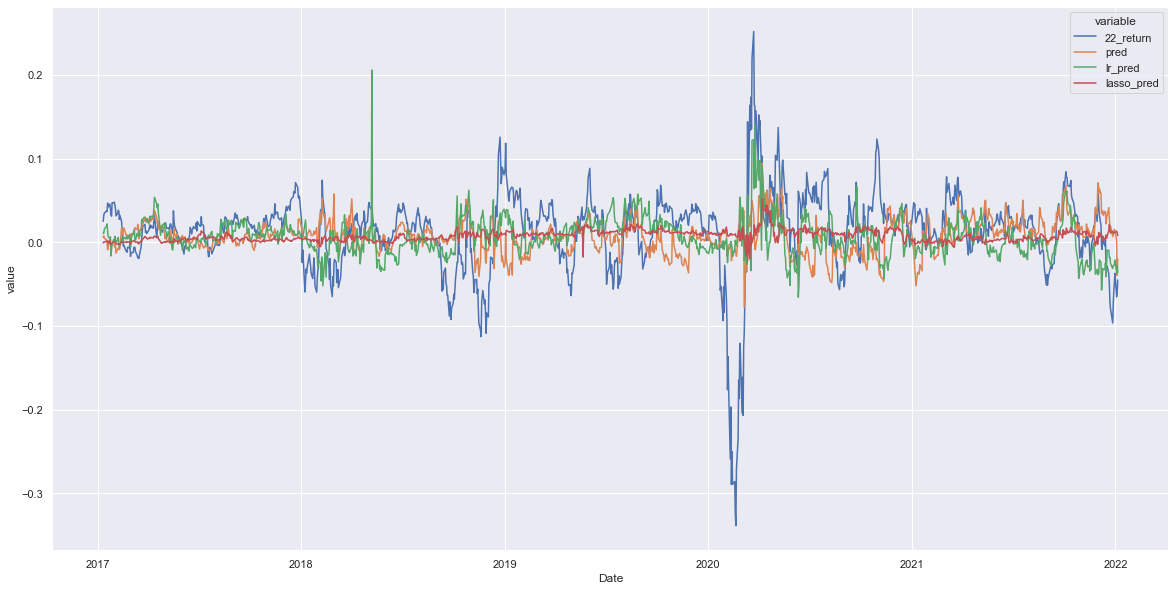

In [398]:
tmp['lasso_pred'] = lasso_pred
# tmp['Date'] = X.iloc[6000:]['Date']
lasso_rmse = mse(lasso_pred, all_y)
print(lasso_rmse)
ml = pd.melt(tmp, id_vars=['Date'])
plt.figure(figsize=(20, 10))
sns.lineplot(data=ml, x='Date', y='value', hue='variable')

## cumsum

<AxesSubplot:xlabel='Date', ylabel='value'>

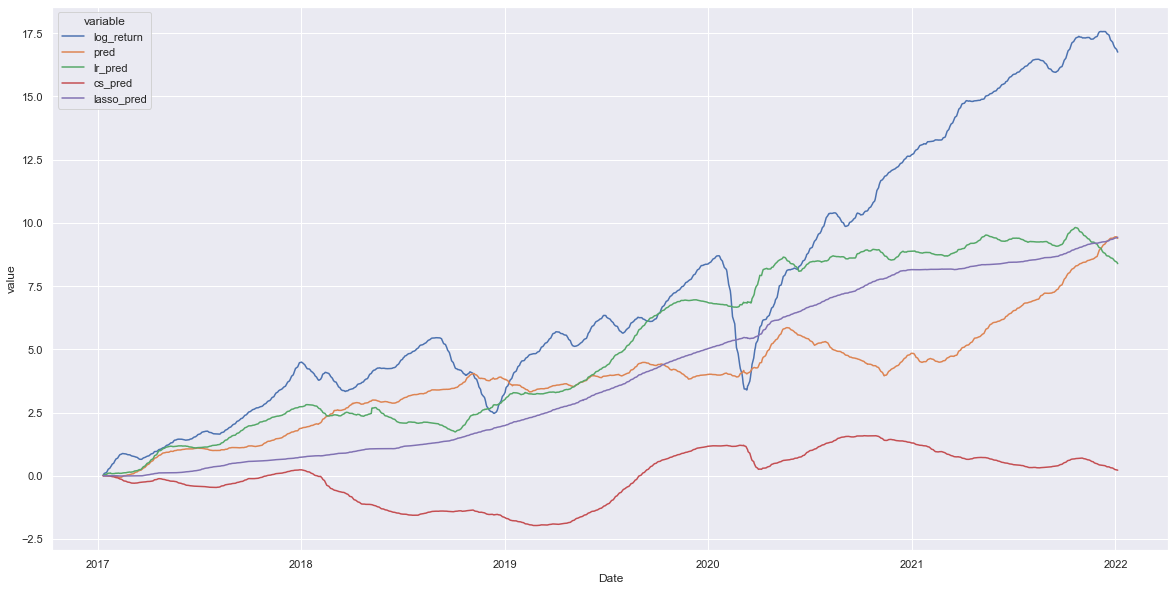

In [334]:
count = tmp.copy()
count = count.drop(['Date'], axis=1).cumsum()
count['Date'] = tmp['Date']
ml_count = pd.melt(count, id_vars=['Date'])
plt.figure(figsize=(20, 10))
sns.lineplot(data=ml_count, x='Date', y='value', hue='variable')

## 3.1 Wealth Accumulation

## 3.2 Actual vs. Forecast Returns

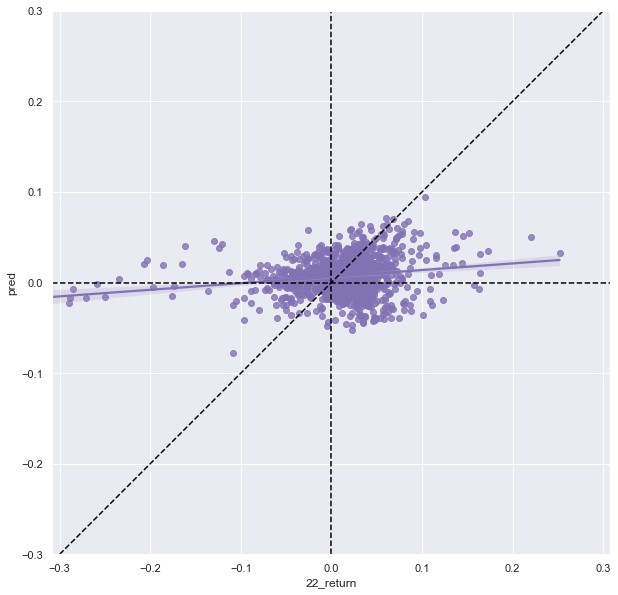

In [396]:
plt.figure(figsize=(10, 10))
g = sns.regplot(x="22_return", y="pred", data=tmp,
                #   kind="reg", truncate=False,
                # xlim=(-0.3, 0.3), ylim=(-0.3, 0.3),
                  color="m")
plt.axis('equal')
plt.axhline(y=0, color='black', linestyle='dashed')
plt.axvline(x=0, color='black', linestyle='dashed')
g.set_xlim(-0.3, 0.3)
g.set_ylim(-0.3, 0.3)
plt.axline([0, 0], [0.1, 0.1], color='black', linestyle='dashed')


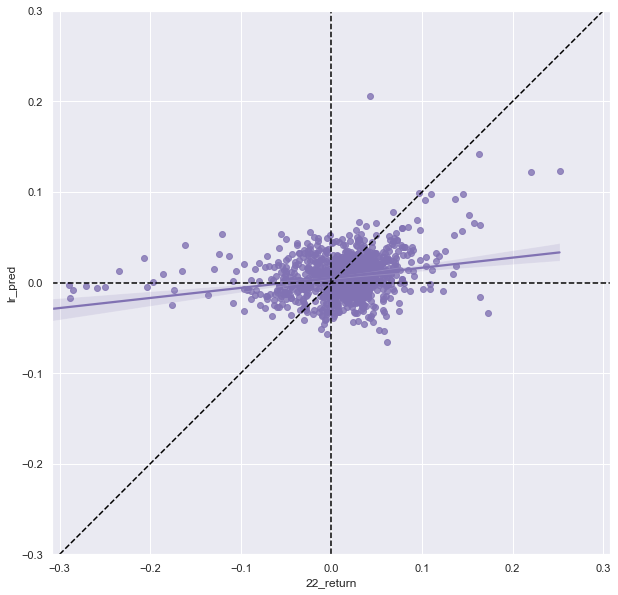

In [395]:
plt.figure(figsize=(10, 10))
g = sns.regplot(x="22_return", y="lr_pred", data=tmp,
                #   kind="reg", truncate=False,
                # xlim=(-0.3, 0.3), ylim=(-0.3, 0.3),
                  color="m")
plt.axis('equal')
plt.axhline(y=0, color='black', linestyle='dashed')
plt.axvline(x=0, color='black', linestyle='dashed')
g.set_xlim(-0.3, 0.3)
g.set_ylim(-0.3, 0.3)
plt.axline([0, 0], [0.1, 0.1], color='black', linestyle='dashed')
